# OLS regressions - baseline for Capstone analysis
In this notebook, I perform OLS regressions using systemwide CaBi trips as the dependent variable.

In [1]:
from util_functions import *
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid')
import statsmodels.graphics.gofplots as gofplots
%matplotlib inline

set_env_path()
conn, cur = aws_connect()
query = """
SELECT *,
CASE day_of_week WHEN 5 THEN 1 WHEN 6 THEN 1 ELSE 0 END AS weekend_dummy,
from final_db"""
df = pd.read_sql(query, con=conn)
df.shape

(2750, 829)

### First specification attempt - theory based
A lot of the variation in daily CaBi rides can be explained by weather.
I decided on the following specification based on trial and error and intuition. 
For our ML analysis, we will want to look into ways to perform feature selection algorithmically (I'm looking into this right now).

That said, the variables I've chosen are fairly arbitrary and could probably be improved, but we shouldn't spend a huge amount of time on baseline stuff. I made sure to try to avoid multicollinearity, for example high and low temperature, population and date, and all of the CaBi data are all highly correlated.

In [3]:
def fitOLS(equation, cov='nonrobust'):
    '''
    This function uses statsmodels.ols to estimate OLS regressions using R/patsy-style syntax.
    
    Args:
        equation (str): A patsy-style regression equation.
                       e.g. 'cabi_trips ~ apparenttemperaturehigh + daylight_hours + rain'
        cov      (str): A specific covariance matrix type. Default is 'nonrobust'. 
                       HC0-HC3 available for heteroskedasticity-robust standard errors.
    Returns:
        results: A RegressionResults object which summarizes the fit of a linear regression model.
    '''
    model = smf.ols('{}'.format(equation), df)
    results = model.fit(cov_type='{}'.format(cov), use_t=True)
    return results

In [6]:
# Using the new weekend_dummy for demonstrative purposes

results = fitOLS('cabi_trips ~ year + daylight_hours + '
                 'apparenttemperaturehigh + rain + snow + '
                 'nats_games + weekend_dummy', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cabi_trips   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1526.
Date:                Fri, 04 May 2018   Prob (F-statistic):               0.00
Time:                        08:50:36   Log-Likelihood:                -24679.
No. Observations:                2750   AIC:                         4.937e+04
Df Residuals:                    2742   BIC:                         4.942e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2.017e+06   3.65e+04    -55.289      0.000   -2.09e+06   -1.95e+06
year                     1001.3313     18.141     55.197      0.000     965.760    1036.903
daylight_hours            191.8238     28.626      6.701      0.000     135.693     247.955
apparenttemperaturehigh    93.6577      2.977     31.456      0.000      87.819      99.496
rain                    -1323.0523     77.535    -17.064      0.000   -1475.086   -1171.019
snow                    -1455.3802    218.798     -6.652      0.000   -1884.405   -1026.355
nats_games                382.2401     96.646      3.955      0.000     192.734     571.746
weekend_dummy             140.2434     86.740      1.617      0.106     -29.840     310.326
==============================================================================
Omnibus:                      103.214   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.926
Skew:                          -0.437   Prob(JB):                     3.34e-27
Kurtosis:                       3.547   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
# Fit the model and print results
# I wanted to use dc_pop instead of year (they're highly correlated) 
# But there are 0s in dc_pop that throw off the analysis

results = fitOLS('cabi_trips ~ year + daylight_hours + '
                 'apparenttemperaturehigh + rain + snow + '
                 'nats_games + C(day_of_week)', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cabi_trips   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     939.9
Date:                Fri, 04 May 2018   Prob (F-statistic):               0.00
Time:                        08:41:27   Log-Likelihood:                -24652.
No. Observations:                2750   AIC:                         4.933e+04
Df Residuals:                    2737   BIC:                         4.941e+04
Df Model:                          12                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2.017e+06   3.62e+04    -55.792      0.000   -2.09e+06   -1.95e+06
C(day_of_week)[T.1.0]     416.1969    131.549      3.164      0.002     158.251     674.143
C(day_of_week)[T.2.0]     638.8117    133.676      4.779      0.000     376.695     900.929
C(day_of_week)[T.3.0]     829.2576    134.505      6.165      0.000     565.516    1092.999
C(day_of_week)[T.4.0]     745.7790    136.101      5.480      0.000     478.907    1012.650
C(day_of_week)[T.5.0]     834.1410    140.857      5.922      0.000     557.944    1110.338
C(day_of_week)[T.6.0]     492.8127    150.462      3.275      0.001     197.783     787.843
year                     1000.9669     17.980     55.672      0.000     965.711    1036.222
daylight_hours            194.1560     28.250      6.873      0.000     138.762     249.550
apparenttemperaturehigh    93.0413      2.933     31.727      0.000      87.291      98.792
rain                    -1353.3990     76.976    -17.582      0.000   -1504.336   -1202.462
snow                    -1550.0663    214.153     -7.238      0.000   -1969.985   -1130.148
nats_games                402.4405     98.207      4.098      0.000     209.874     595.007
==============================================================================
Omnibus:                      100.724   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.099
Skew:                          -0.412   Prob(JB):                     1.13e-27
Kurtosis:                       3.635   Cond. No.                     1.85e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.85e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our results look good.

The R-squared tells us that about 74% of the variance in cabi_trips is explained by the variance in the explanatory variables.

The low p-values indicate that the results we found are all statistically significant.

Each of the coefficient estimates indicates the average change in daily CaBi trips associated with a one-unit increase in the explanatory variable, all else held equal. For dummy variables, this can be interpreted as an on-off switch, so on days when it snows, we should expect 1550 fewer rides.

There are other things to worry about, though. Statistical programming packages often include diagnostic plots by default, but statsmodels doesn't. I explain three of these plots below.

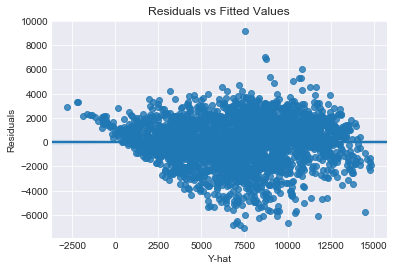

In [4]:
'''Homoskedasticity is when the variance/scatter/spread of the residuals is 
constant for all values of the fitted values. It is an assumption under OLS.

Heteroskedasticity is when the variance of the residuals changes as the fitted values change.
If not addressed, it can lead to biased estimators.
If our residuals were heteroskedastic, we would expect a scatter plot to form a funnel shape,
and a regression line to have a slope.
'''

# Regplot fits a regression line to a scatterplot
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

It doesn't look like there's heteroskedasticity, and the regression line is flat. However I think given our sample size and the significance of our variables, it couldn't hurt to specify heteroskedasticity-robust standard errors (the cov=HC0 argument in fitOLS). 

In practice I rarely see standard errors that aren't robust to either heteroskedasticity or clustering. (If we wanted to cluster, we would have to choose variables to cluster on, and I haven't looked into that for our data).

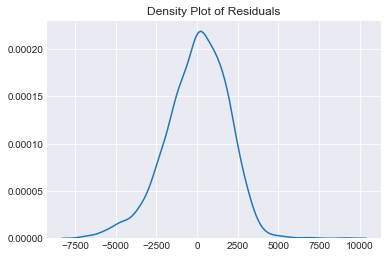

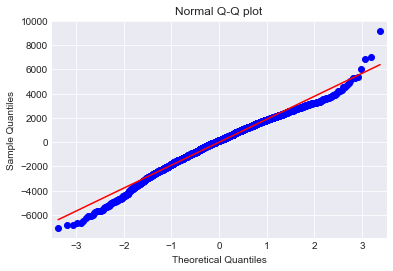

In [5]:
'''Normality of the residuals with mean 0 is another assumption under OLS.
If residuals are nonnormal and not approximately centered at 0, the model is probably misspecified.
The first chart is a kernel density estimation and the second is a Q-Q plot.

Q-Q plots compare two datasets to see whether or not they come from the same distribution.
If they do, the points should form a straight line.
Here, we have a Normal Q-Q plot, where our residuals are being compared against a normal distribution.
'''

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normal?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()

The residuals appear to be approximately centered around 0.

The third chart shows that our residuals are close to normal, but at the extreme ends of our distribution we get farther from a normal distribution.

### Second specification attempt - dockless?
Next, I add dless_trips_all to the specification to see if there's any effect.

In [6]:
results = fitOLS('cabi_trips ~ year + daylight_hours +'
                 'apparenttemperaturehigh + rain + snow + '
                 'nats_games + C(day_of_week) + dless_trips_all', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cabi_trips   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     867.8
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:54:00   Log-Likelihood:                -24649.
No. Observations:                2750   AIC:                         4.933e+04
Df Residuals:                    2736   BIC:                         4.941e+04
Df Model:                          13                                         
Covariance Type:                  HC0                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -2.051e+06   3.85e+04    -53.224      0.000   -2.13e+06   -1.98e+06
C(day_of_week)[T.1.0]     418.6946    131.240      3.190      0.001     161.355     676.034
C(day_of_week)[T.2.0]     643.6174    133.326      4.827      0.000     382.187     905.048
C(day_of_week)[T.3.0]     834.7996    134.238      6.219      0.000     571.582    1098.017
C(day_of_week)[T.4.0]     750.6864    135.931      5.523      0.000     484.148    1017.224
C(day_of_week)[T.5.0]     840.5945    140.605      5.978      0.000     564.891    1116.298
C(day_of_week)[T.6.0]     496.2995    150.329      3.301      0.001     201.529     791.070
year                     1017.7115     19.169     53.092      0.000     980.125    1055.298
daylight_hours            176.7309     28.941      6.107      0.000     119.982     233.480
apparenttemperaturehigh    94.0238      2.945     31.929      0.000      88.250      99.798
rain                    -1358.4120     76.769    -17.695      0.000   -1508.942   -1207.882
snow                    -1559.6736    214.899     -7.258      0.000   -1981.054   -1138.293
nats_games                396.6625     97.860      4.053      0.000     204.776     588.549
dless_trips_all            -0.3148      0.137     -2.302      0.021      -0.583      -0.047
==============================================================================
Omnibus:                      101.954   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.457
Skew:                          -0.413   Prob(JB):                     3.47e-28
Kurtosis:                       3.649   Cond. No.                     1.99e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R squared is slightly higher.

dless_trips_all is statistically significant, but its coefficient is small. An increase of 100 dockless trips is associated with 33 fewer CaBi trips. Its upper bound is also fairly close to 0. 

For the sake of brevity I don't include the diagnostic plots here because they don't change much after adding just one independent variable.

### Third specification attempt - transformations
Next, I try taking the natural log of certain variables. 
When you include a logged variable, its interpretation changes to percentage change instead of unit change. I get into specifics in the cell after the regression results.

Logging variables is also very good for dealing with outliers. OLS is sensitive to outliers - we saw this demonstrated in class when we removed one observation from the IQ ~ TVhours regression. Logging a variable with a long right tail will often make it approximately normal, which is better for OLS.

In [7]:
# I ran into errors trying to log cabi_trips because the log of 0 is undefined.
# Ended up having to drop the four observations where cabi_trips==0
df = df[df.cabi_trips != 0]
df.shape

(2746, 828)

In [8]:
results = fitOLS('np.log(cabi_trips) ~ year + daylight_hours + '
                 'np.log(apparenttemperaturehigh) + rain + snow + nats_games + C(day_of_week) + '
                 'dless_trips_all', cov='HC0')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(cabi_trips)   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     313.7
Date:                Mon, 30 Apr 2018   Prob (F-statistic):               0.00
Time:                        17:54:00   Log-Likelihood:                -1537.2
No. Observations:                2746   AIC:                             3102.
Df Residuals:                    2732   BIC:                             3185.
Df Model:                          13                                         
Covariance Type:                  HC0                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -379.7281      9.539    -39.806      0.000    -398.433    -361.023
C(day_of_week)[T.1.0]               0.0766      0.032      2.384      0.017       0.014       0.140
C(day_of_week)[T.2.0]               0.1301      0.029      4.547      0.000       0.074       0.186
C(day_of_week)[T.3.0]               0.1478      0.030      4.950      0.000       0.089       0.206
C(day_of_week)[T.4.0]               0.1340      0.031      4.257      0.000       0.072       0.196
C(day_of_week)[T.5.0]               0.1622      0.029      5.672      0.000       0.106       0.218
C(day_of_week)[T.6.0]               0.0700      0.029      2.383      0.017       0.012       0.128
year                                0.1909      0.005     40.325      0.000       0.182       0.200
daylight_hours                      0.0530      0.006      8.241      0.000       0.040       0.066
np.log(apparenttemperaturehigh)     0.8136      0.041     19.879      0.000       0.733       0.894
rain                               -0.2168      0.017    -12.851      0.000      -0.250      -0.184
snow                               -0.3684      0.076     -4.845      0.000      -0.517      -0.219
nats_games                          0.0307      0.020      1.564      0.118      -0.008       0.069
dless_trips_all                  -8.09e-05    1.8e-05     -4.485      0.000      -0.000   -4.55e-05
==============================================================================
Omnibus:                     1606.578   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27995.720
Skew:                          -2.421   Prob(JB):                         0.00
Kurtosis:                      17.874   Cond. No.                     2.00e+06
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large,  2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Since we have some logged variables, the interpretation of the coefficients changes.

Before, the interpretation of apparenttemperaturehigh's effect on cabi_rides was basically "Holding all else equal, how many more cabi rides should we see if the feels-like temperature is one degree (F) higher?"

Now that both are logged, the coefficient of 0.8136 means "Holding all else equal, if feels-like temperature rises by 1%, we expect there to be a 0.81% increase in CaBi rides." 

I explain the interpretation of the dummy coefficients below.

In [9]:
# When you have a logged dependent variable, be careful with dummies
# The effect is asymmetrical!
# more: https://davegiles.blogspot.com/2011/03/dummies-for-dummies.html
print('If rain switches from 0 to 1, the % impact on cabi_trips is ', 100*(np.exp(-0.2168) - 1))
print('If rain switches from 1 to 0, the % impact on cabi_trips is ', 100*(np.exp(0.2168) - 1))
print('If snow switches from 0 to 1, the % impact on cabi_trips is ', 100*(np.exp(-0.3684) - 1))
print('If snow switches from 1 to 0, the % impact on cabi_trips is ', 100*(np.exp(0.3684) - 1))

If rain switches from 0 to 1, the % impact on cabi_trips is  -19.490902860146488
If rain switches from 1 to 0, the % impact on cabi_trips is  24.209565816256216
If snow switches from 0 to 1, the % impact on cabi_trips is  -30.815960982195236
If snow switches from 1 to 0, the % impact on cabi_trips is  44.542009139224504


All in all, this third specification isn't that appealing. nats_games is no longer significant, the R squared is lower, and the dummy variables don't make as much intuitive sense.

Looking at the charts below you can see that things look worse than before. This particular specification is no good.

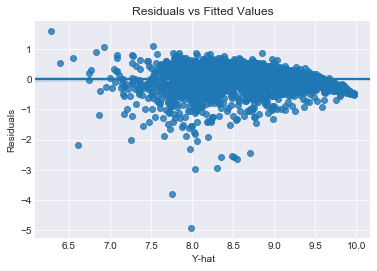

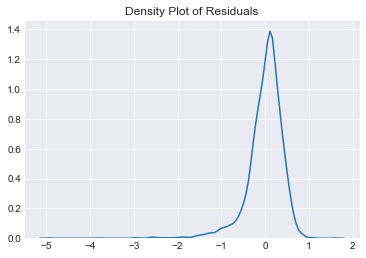

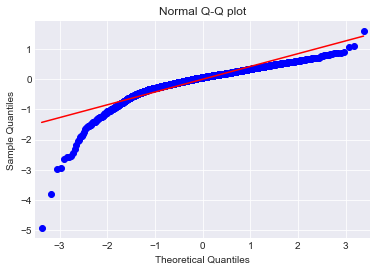

In [10]:
# Heteroskedasticity?
plt.title('Residuals vs Fitted Values')
sns.regplot(results.fittedvalues, results.resid)
plt.xlabel('Y-hat')
plt.ylabel('Residuals')
plt.show()

# How are our residuals distributed?
plt.title('Density Plot of Residuals')
sns.kdeplot(results.resid)
plt.show()

# How close are our residuals to normality?
fig = gofplots.qqplot(results.resid, line='s')
plt.title("Normal Q-Q plot")
plt.show()